In [97]:
import joblib
import numpy as np
import pandas as pd
import re
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, shapiro
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    median_absolute_error,
    root_mean_squared_error,
    r2_score,
    make_scorer
    )
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
RANDOM_STATE = 42

In [98]:
# несколько полезных фуункций
def fill_missing_with_mean(df):
    """
    Функция для заполнения пропущенных значений средним значением столбца датафрейма df
    """
    numeric_columns = df.select_dtypes(include=['float', 'int'])
    for column in numeric_columns:
        if df[column].notna().any():
            df[column] = df[column].fillna(df[column].mean().round())
    return df

def add_smth_to_col_name(df, add_str):
    """
    Функция, добавляющая префикс add_str к наименованиям всех столбцов датафрейма df
    """
    new_names = []
    for col in df.columns:
        name = f'{add_str}{col}'
        new_names.append(name)
    df.columns = new_names
    return df

def norm_without_outliers(df, str, value=0.05):
    """
    Функция, возвращающая два списка со значимостью value по методу Шапиро-Уилка:
    - рамановские сдвиги датафрейма df, значения которых принадлежат нормальному распределению (norm)
    - p-value теста Шапиро-Уилка соответствующих столбцов из списка norm
    str - исключаемый префикс столбцов
    """
    norm = []
    p_list = []
    for col in df.columns:
        stat, p = shapiro(df[col].dropna().values)
        if p < value:
            norm.append(re.sub(f'{str}_', '', col))
            p_list.append(p)
        else:
            norm = norm
            p_list = p_list
    
    return norm, p_list

def chi2_without_outliers(df_1, df_2, str, value=0.05):
    """
    Функция, возвращающая два списка со значимостью value теста Хи-квадрат:
    - рамановские сдвиги, значения которых возможно зависимы
    - p-value теста Хи-квадрат соответствующих рамановских сдвигов из списка chi2
    df_1, df_2 - первый и второй датафреймы, содержащие значения для аналогичных рамановских сдвигов 
    str - исключаемый префикс столбцов
    """
    chi2 = []
    p_list = []
    for col_1, col_2 in zip(df_1.columns, df_2.columns):
        table = pd.concat([df_1[col_1], df_2[col_2]], axis=1)
        table = table.dropna().values.reshape(2, -1)
        stat, p, dof, expected = chi2_contingency(table)
        if p < value:
            chi2.append(re.sub(f'{str}_', '', col_1))
            p_list.append(p)
        else:
            chi2 = chi2
            p_list = p_list

    return chi2, p_list

def anova_without_outliers(df_1, df_2, df_3, str, value=0.05):
    """
    Функция, возвращающая два списка со значимостью value теста ANOVA (для двух переменных):
    - рамановские сдвиги, средние значения которых различны для трёх веществ
    - p-value теста ANOVA соответствующих рамановских сдвигов из списка anova
    df_1, df_2 - первый, второй и третий датафреймы, содержащие значения для аналогичных рамановских сдвигов 
    str - исключаемый префикс столбцов
    """
    anova = []
    p_list = []
    for col_1, col_2, col_3 in zip(df_1.columns, df_2.columns, df_3.columns):
        stat, p = f_oneway(
            df_1[col_1].dropna().values, 
            df_2[col_2].dropna().values, 
            df_3[col_3].dropna().values
            )
        if p < value:
            anova.append(re.sub(f'{str}_', '', col_1))
            p_list.append(p)
        else:
            anova = anova
            p_list = p_list
            
    return anova, p_list

def anova_without_outliers_for_two(df_1, df_2, str, value=0.05):
    """
    Функция, возвращающая два списка со значимостью value теста ANOVA (для трёх переменных):
    - рамановские сдвиги, средние значения которых различны для двух веществ
    - p-value теста ANOVA соответствующих рамановских сдвигов из списка anova
    df_1, df_2 - первый и второй датафреймы, содержащие значения для аналогичных рамановских сдвигов 
    str - исключаемый префикс столбцов
    """
    anova = []
    p_list = []
    for col_1, col_2 in zip(df_1.columns, df_2.columns):
        stat, p = f_oneway(
            df_1[col_1].dropna().values, 
            df_2[col_2].dropna().values
            )
        if p < value:
            anova.append(re.sub(f'{str}_', '', col_1))
            p_list.append(p)
        else:
            anova = anova
            p_list = p_list
            
    return anova, p_list

def remove_outliers(df, column):
    """
    Функция, исключающая в столбце column датафрейма df
    строки, содержащие значения, выходящие за пределы 1,5 межквартильных размахов (IQR), 
    разницы между верхним и нижним квартилями.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [99]:
# загрузка таблицы с значениями интенсивности флуоресценции 
df = pd.read_excel('tab_2.xlsx')
df.index = df['Рамановский сдвиг']
df.columns = df.iloc[0,:]
df = df.iloc[1:, 2:]
df = df.astype('float')

In [100]:
# данные группируем в таблицы по вещестам
df_s = df['Сырой']
df_f = df['Формалин']
df_p = df['Парафин']
df_s.columns = np.arange(28)
df_f.columns = np.arange(28)
df_p.columns = np.arange(28)

In [101]:
print(f'Количество пропущенных значений в таблицах: \nСырое вещество: {df_s.isna().sum().sum()}')
print(f'Формалин: {df_f.isna().sum().sum()}')
print(f'Парафин: {df_p.isna().sum().sum()}')

Количество пропущенных значений в таблицах: 
Сырое вещество: 0
Формалин: 0
Парафин: 1


In [102]:
# заполняем пропущенное значение средним
df_p = fill_missing_with_mean(df_p.T)
df_p = df_p.T

In [103]:
# приведём значения корреляции средних значений интенсивности флуоресценции в зависимости от вещества
df_mean = pd.DataFrame({
    'Сырой': df_s.mean(axis=1),
    'Формалин': df_f.mean(axis=1),
    'Парафин': df_p.mean(axis=1)})
# коэффициент корреляции приведён по Спирмэну, т.к. учитывает ранги
df_mean.corr('spearman')

,Сырой,Формалин,Парафин
Сырой,1.000,0.643,0.526
Формалин,0.643,1.000,0.673
Парафин,0.526,0.673,1.000


In [104]:
# импортируем данные пациентов
features = pd.read_excel('tab_1.xlsx')
features = features.iloc[:, 1:8]
features.columns = ['Возраст', 'Срок', 'Роды', 'Апгар', 'Масса_плод', 'Рост', 'Масса_плацента']

In [105]:
# по очереди применяем к таблицам следующие преобразования: 
# - транспонируем, 
# - делаем копию для дальнейшего преобразования в EDA, 
# - добавляем префикс к наименованиям столбцов
df_s = df_s.T
df_s_eda = df_s.copy()
df_s = add_smth_to_col_name(df_s, 'сырой_')
df_f = df_f.T
df_f_eda = df_f.copy()
df_f = add_smth_to_col_name(df_f, 'форм_')
df_p = df_p.T
df_p_eda = df_p.copy()
df_p = add_smth_to_col_name(df_p, 'пар_')

In [106]:
# соединяем признаки пациентов со значениями интенсивности флуоресценции
df_features = pd.concat([features, df_s, df_f, df_p], axis=1)
df_features.head()

,Возраст,Срок,Роды,Апгар,Масса_плод,Рост,Масса_плацента,сырой_415.0,сырой_533.0,сырой_628.0,сырой_641.0,сырой_720.0,сырой_753.0,сырой_810.0,сырой_830.0,сырой_890.0,сырой_933.0,сырой_957.0,сырой_1002.0,сырой_1048.0,сырой_1117.0,сырой_1157.0,сырой_1174.0,сырой_1204.0,сырой_1230.0,сырой_1287.0,сырой_1300.0,сырой_1304.0,сырой_1361.0,сырой_1365.0,сырой_1370.0,сырой_1445.0,сырой_1463.0,сырой_1528.0,сырой_1554.0,сырой_1609.0,сырой_1627.0,сырой_2225.0,сырой_2554.0,сырой_2915.0,форм_415.0,форм_533.0,форм_628.0,форм_641.0,форм_720.0,форм_753.0,форм_810.0,форм_830.0,форм_890.0,форм_933.0,форм_957.0,форм_1002.0,форм_1048.0,форм_1117.0,форм_1157.0,форм_1174.0,форм_1204.0,форм_1230.0,форм_1287.0,форм_1300.0,форм_1304.0,форм_1361.0,форм_1365.0,форм_1370.0,форм_1445.0,форм_1463.0,форм_1528.0,форм_1554.0,форм_1609.0,форм_1627.0,форм_2225.0,форм_2554.0,форм_2915.0,пар_415.0,пар_533.0,пар_628.0,пар_641.0,пар_720.0,пар_753.0,пар_810.0,пар_830.0,пар_890.0,пар_933.0,пар_957.0,пар_1002.0,пар_1048.0,пар_1117.0,пар_1157.0,пар_1174.0,пар_1204.0,пар_1230.0,пар_1287.0,пар_1300.0,пар_1304.0,пар_1361.0,пар_1365.0,пар_1370.0,пар_1445.0,пар_1463.0,пар_1528.0,пар_1554.0,пар_1609.0,пар_1627.0,пар_2225.0,пар_2554.0,пар_2915.0
0,25,39,1,8.900,4070,56,593,103.000,118.000,129.000,101.000,107.000,152.000,101.000,70.000,68.000,61.000,107.000,167.000,17.000,123.000,285.000,168.000,91.000,277.000,22.000,132.000,144.000,201.000,176.000,195.000,77.000,70.000,183.000,266.000,262.000,284.000,30.000,94.000,378.000,665.000,374.000,212.000,204.000,108.000,162.000,35.000,117.000,29.000,69.000,42.000,84.000,176.000,105.000,161.000,170.000,87.000,84.000,107.000,139.000,6.000,76.000,85.000,162.000,84.000,128.000,85.000,30.000,176.000,67.000,183.000,376.000,335.000,2645.000,2200.000,1558.000,1457.000,921.000,489.000,270.000,392.000,276.000,146.000,198.000,97.000,154.000,39.000,90.000,62.000,51.000,66.000,90.000,147.000,31.000,65.000,179.000,45.000,59.000,114.000,203.000,80.000,78.000,250.000,178.000,128.000,484.000
1,39,40,2,9.900,3500,52,436,31.000,42.000,20.000,44.000,43.000,82.000,54.000,61.000,10.000,49.000,72.000,35.000,64.000,93.000,84.000,93.000,53.000,44.000,57.000,80.000,81.000,89.000,68.000,101.000,9.000,29.000,6.000,58.000,41.000,118.000,46.000,61.000,82.000,637.000,328.000,232.000,190.000,144.000,149.000,56.000,77.000,4.000,111.000,61.000,37.000,136.000,132.000,71.000,124.000,151.000,28.000,108.000,111.000,64.000,197.000,158.000,49.000,168.000,80.000,183.000,36.000,182.000,111.000,284.000,349.000,258.000,2671.000,2128.000,1476.000,1328.000,877.000,548.000,262.000,218.000,263.000,149.000,154.000,22.000,36.000,96.000,197.000,97.000,113.000,291.000,84.000,275.000,53.000,232.000,152.000,286.000,353.000,168.000,332.000,165.000,201.000,188.000,354.000,291.000,517.000
2,29,39,1,8.900,2740,48,269,57.000,43.000,52.000,67.000,23.000,84.000,44.000,76.000,67.000,82.000,58.000,75.000,98.000,82.000,80.000,73.000,60.000,73.000,32.000,36.000,55.000,49.000,4.000,87.000,11.000,11.000,12.000,55.000,24.000,72.000,105.000,23.000,74.000,655.000,398.000,259.000,198.000,134.000,159.000,63.000,114.000,165.000,60.000,101.000,68.000,214.000,103.000,147.000,143.000,149.000,139.000,83.000,54.000,68.000,123.000,99.000,208.000,120.000,20.000,176.000,166.000,126.000,248.000,196.000,364.000,319.000,2085.000,1627.000,1235.000,1159.000,657.000,450.000,138.000,225.000,190.000,127.000,62.000,175.000,111.000,32.000,207.000,145.000,210.000,130.000,200.000,242.000,194.000,118.000,142.000,237.000,98.000,37.000,311.000,337.000,331.000,246.000,173.000,433.000,683.000
3,34,39,5,9.100,3610,51,439,30.000,39.000,60.000,80.000,61.000,50.000,82.000,42.000,54.000,94.000,99.000,51.000,96.000,84.000,117.000,93.000,56.000,78.000,22.000,113.000,74.000,117.000,98.000,126.000,4.000,4.000,34.000,181.000,110.000,162.000,44.000,49.000,165.000,1004.000,626.000,399.000,353.000,176.000,171.000,59.000,54.000,90.000,105.000,103.000,118.000,108.000,41.000,75.000,111.000,94.000,46.000,87.000,88.000,141.000,153.000,113.000,57.000,94.

# EDA

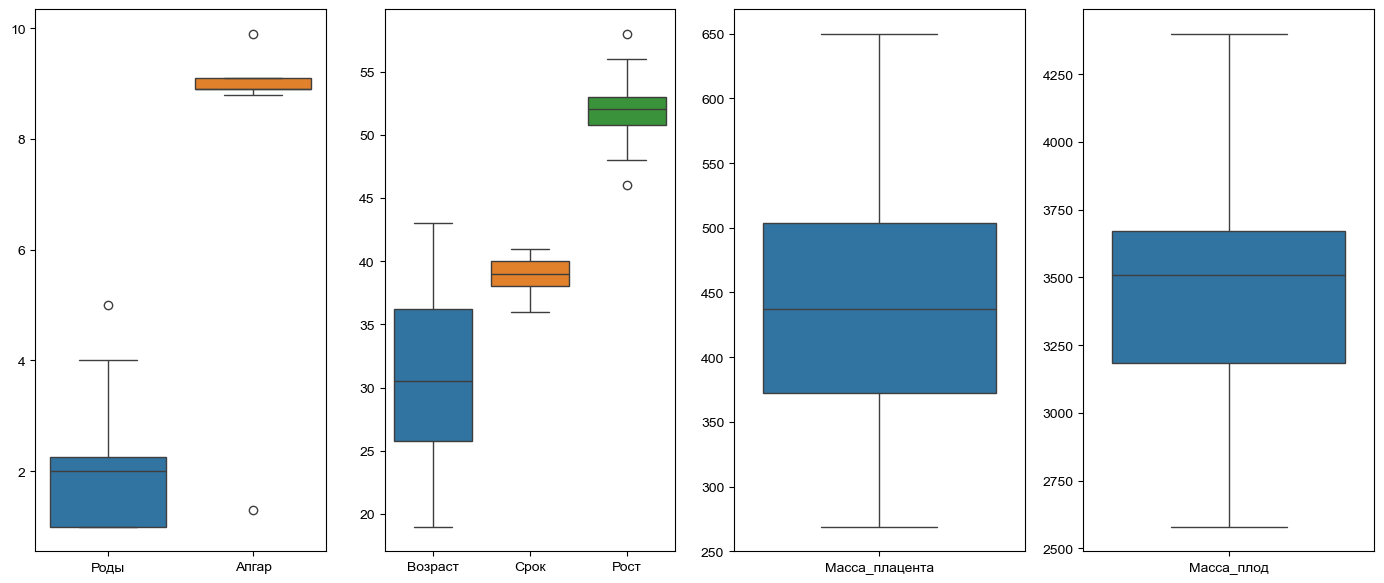

In [29]:
# боксплоты признаков пациентов
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 6))
sns.set_context("notebook")
sns.set_style("ticks",{'axes.grid' : True})

sns.boxplot(features[['Роды', 'Апгар']], ax=axes[0])
sns.boxplot(features[['Возраст', 'Срок', 'Рост']], ax=axes[1])
sns.boxplot(features[['Масса_плацента']], ax=axes[2])
sns.boxplot(features[['Масса_плод']], ax=axes[3])

plt.tight_layout()
plt.show()

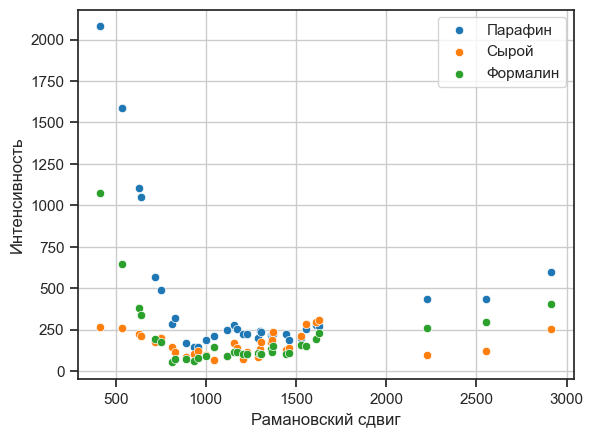

In [ ]:
# точечный график зависимости средних значений интенсивности флуоресценции в зависимости от рамановского сдвига и вещества.
sns.scatterplot(df_p_eda.T, x=df_p_eda.columns, y=df_p_eda.mean(), label='Парафин')
sns.scatterplot(df_s_eda.T, x=df_s_eda.columns, y=df_s_eda.mean(), label='Сырой')
sns.scatterplot(df_f_eda.T, x=df_f_eda.columns, y=df_f_eda.mean(), label='Формалин')
plt.ylabel('Интенсивность')
plt.show()

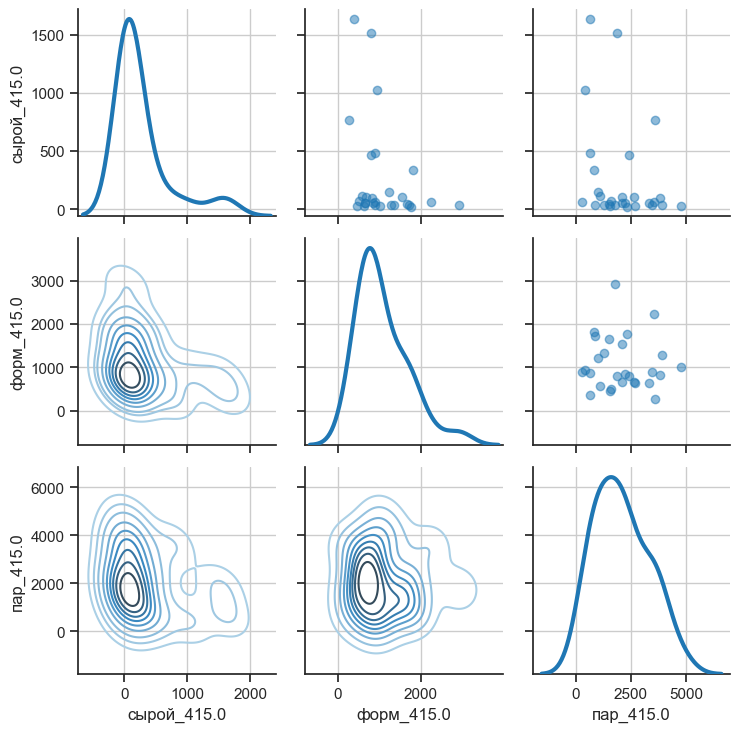

In [35]:
# здесь и далее (всего в трёх ячейках) приведены тройные графики, показывающие взаимосвязь значений интенсивности флуоресценции в зависимости от вещества.
# [Каждой ячейке соответствует один рамановский сдвиг].
# на диагоналях и ниже диагоналей приведены графики ядерной плотности
# выше диагоналей показаны точечные графики
g = sns.PairGrid(df_features[['сырой_415.0', 'форм_415.0', 'пар_415.0']], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap='Blues_d')
g.map_upper(plt.scatter, alpha=0.5)
g.map_diag(sns.kdeplot, lw=3)
plt.show()

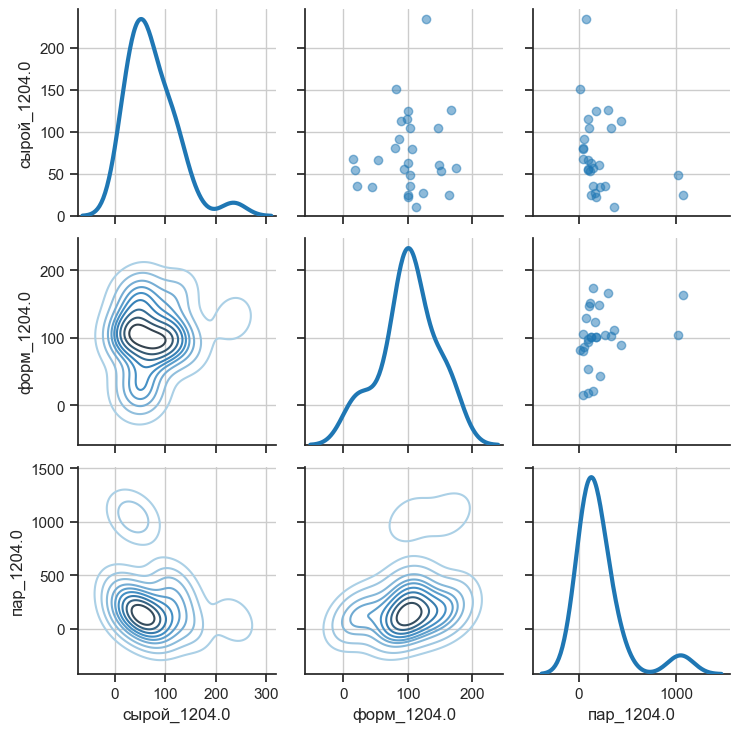

In [36]:
g = sns.PairGrid(df_features[['сырой_1204.0', 'форм_1204.0', 'пар_1204.0']], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap='Blues_d')
g.map_upper(plt.scatter, alpha=0.5)
g.map_diag(sns.kdeplot, lw=3)
plt.show()

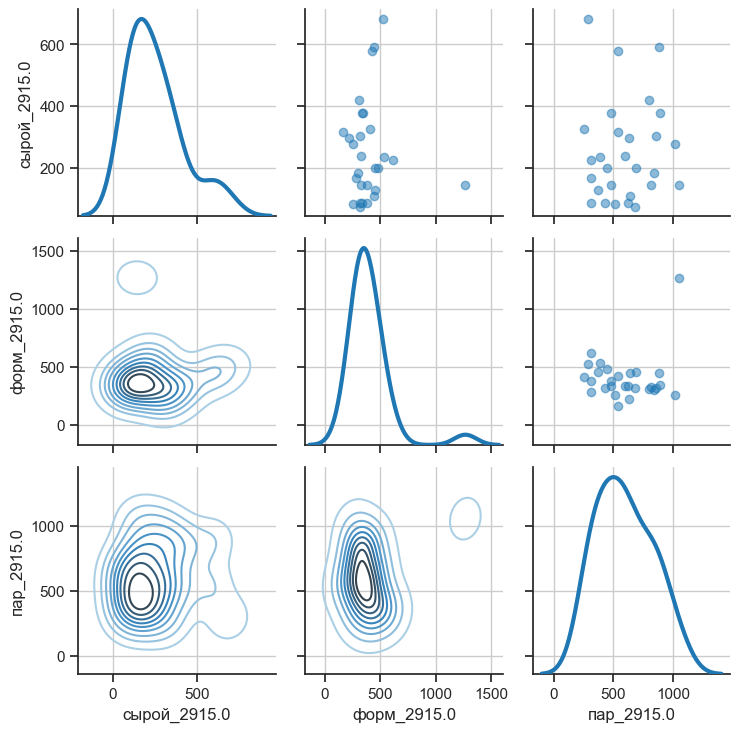

In [37]:
g = sns.PairGrid(df_features[['сырой_2915.0', 'форм_2915.0', 'пар_2915.0']], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap='Blues_d')
g.map_upper(plt.scatter, alpha=0.5)
g.map_diag(sns.kdeplot, lw=3)
plt.show()

# Shapiro (тест на принадлежность к нормальному распределению)
Выдвигаются две гипотезы: "принадлежит нормальному распределению" и "не принадлежит" и устанавливается уровень значимости 0.05. Тест шапиро-Уилка оценивает сходства данной выборки с нормальным распределением.

In [52]:
norm_s, p_list_s = norm_without_outliers(df_s, 'сырой')
norm_f, p_list_f = norm_without_outliers(df_f, 'форм')
norm_p, p_list_p = norm_without_outliers(df_p, 'пар')
print(f'Сдвиги, данные которых не принадлежат нормальному распределению:\nСырой: {norm_s}\nФормалин: {norm_f}\nПарафин: {norm_p}\n')

print(f'Сдвиги, данные которых не принадлежат нормальному распределению для всех сред:\n{set(norm_s).intersection(norm_f).intersection(norm_p)}')

Сдвиги, данные которых не принадлежат нормальному распределению:
Сырой: ['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '933.0', '957.0', '1002.0', '1157.0', '1204.0', '1230.0', '1287.0', '1300.0', '1304.0', '1361.0', '1365.0', '1370.0', '1445.0', '1463.0', '1528.0', '1554.0', '1609.0', '1627.0', '2225.0', '2554.0', '2915.0']
Формалин: ['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '1445.0', '1463.0', '1528.0', '1554.0', '1609.0', '1627.0', '2915.0']
Парафин: ['810.0', '957.0', '1002.0', '1048.0', '1117.0', '1157.0', '1174.0', '1204.0', '1230.0', '1287.0', '1300.0', '1304.0', '1361.0', '1365.0', '1370.0', '1445.0', '1627.0', '2225.0', '2554.0']

Сдвиги, данные которых не принадлежат нормальному распределению для всех сред:
{'1445.0', '1627.0'}


# Хи-квадрат тест
Выдвигаются две гипотезы: "Переменные независимы" и "Связаны две переменные" и устанавливается уровень значимости 0.05. Тест хи-квадрат оценивает частоты данных выборок и ожидаемые частоты для установления независимости двух переменных.

In [44]:
chi2_sp, chi2_p_list_sp = chi2_without_outliers(df_s, df_p, 'сырой')
chi2_sf, chi2_p_list_sf = chi2_without_outliers(df_s, df_f, 'сырой')
chi2_pf, chi2_p_list_pf = chi2_without_outliers(df_p, df_f, 'пар')
print(f'Сдвиги, возможно зависимые друг от друга для сырых и парафина:\n{chi2_sp}')
print(f'Сдвиги, возможно зависимые друг от друга для сырых и формалина:\n{chi2_sf}')
print(f'Сдвиги, возможно зависимые друг от друга для парафина и формалина:\n{chi2_pf}')
print('Выборки для всех аналитов возможно зависимы')

Сдвиги, возможно зависимые друг от друга для сырых и парафина:
['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '933.0', '957.0', '1002.0', '1048.0', '1117.0', '1157.0', '1174.0', '1204.0', '1230.0', '1287.0', '1300.0', '1304.0', '1361.0', '1365.0', '1370.0', '1445.0', '1463.0', '1528.0', '1554.0', '1609.0', '1627.0', '2225.0', '2554.0', '2915.0']
Сдвиги, возможно зависимые друг от друга для сырых и формалина:
['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '933.0', '957.0', '1002.0', '1048.0', '1117.0', '1157.0', '1174.0', '1204.0', '1230.0', '1287.0', '1300.0', '1304.0', '1361.0', '1365.0', '1370.0', '1445.0', '1463.0', '1528.0', '1554.0', '1609.0', '1627.0', '2225.0', '2554.0', '2915.0']
Сдвиги, возможно зависимые друг от друга для парафина и формалина:
['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '933.0', '957.0', '1002.0', '1048.0', '1117.0', '1157.0', '1174.0', '1204.0', '1230.

# ANOVA (тест на сравнение средних (более двух групп))
Выдвигаются две гипотезы: "средние значения совокупности равны" и "средние значения выборок различаются" и устанавливается уровень значимости 0.05. Тест ANOVA оценивает статистическую значимость различия между средними выборок.

In [49]:
anova_list, anova_p_list = anova_without_outliers(df_s, df_f, df_p, 'сырой')
anova_list_sp, anova_p_list_sp = anova_without_outliers_for_two(df_s, df_p, 'сырой')

print(f'Сдвиги, средние значения которых различны для всех сред:\n{anova_list}\n')
print(f'Сдвиги, средние значения которых различны\
 для сырых и парафина:\n{anova_list_sp}')

Сдвиги, средние значения которых различны для всех сред:
['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '933.0', '957.0', '1002.0', '1048.0', '1117.0', '1157.0', '1174.0', '1204.0', '1230.0', '1287.0', '1300.0', '1304.0', '1365.0', '1445.0', '1554.0', '2225.0', '2554.0', '2915.0']

Сдвиги, средние значения которых различны для сырых и парафина:
['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '1002.0', '1048.0', '1117.0', '1174.0', '1204.0', '1230.0', '1287.0', '1300.0', '1445.0', '2225.0', '2554.0', '2915.0']


# IQR (исключение выбросов)
Определяется межквартильный размах (IQR) для каждого рамановского сдвига по каждому аналиту, границы межквартильного размаха увеличиваются на 1.5*IQR вверх и вниз от 1го и 3го квартилей соответственно. И исключаются данные, выходящие за пределы установленных границ.

In [54]:
# создаём копии таблиц с пустыми значениями в ячейках, выходящих за пределы 1,5*IQR
df_s_iqr = remove_outliers(df_s, df_s.columns)
df_f_iqr = remove_outliers(df_f, df_f.columns)
df_p_iqr = remove_outliers(df_p, df_p.columns)

In [56]:
# Здесь и далее закрашены исключённые значения
df_s_iqr.style.highlight_null("#fc5a50")

,сырой_415.0,сырой_533.0,сырой_628.0,сырой_641.0,сырой_720.0,сырой_753.0,сырой_810.0,сырой_830.0,сырой_890.0,сырой_933.0,сырой_957.0,сырой_1002.0,сырой_1048.0,сырой_1117.0,сырой_1157.0,сырой_1174.0,сырой_1204.0,сырой_1230.0,сырой_1287.0,сырой_1300.0,сырой_1304.0,сырой_1361.0,сырой_1365.0,сырой_1370.0,сырой_1445.0,сырой_1463.0,сырой_1528.0,сырой_1554.0,сырой_1609.0,сырой_1627.0,сырой_2225.0,сырой_2554.0,сырой_2915.0
0,103.000000,118.000000,129.000000,101.000000,107.000000,152.000000,101.000000,70.000000,68.000000,61.000000,107.000000,167.000000,17.000000,123.000000,285.000000,168.000000,91.000000,nan,22.000000,132.000000,144.000000,201.000000,176.000000,195.000000,77.000000,70.000000,183.000000,266.000000,262.000000,284.000000,30.000000,94.000000,378.000000
1,31.000000,42.000000,20.000000,44.000000,43.000000,82.000000,54.000000,61.000000,10.000000,49.000000,72.000000,35.000000,64.000000,93.000000,84.000000,93.000000,53.000000,44.000000,57.000000,80.000000,81.000000,89.000000,68.000000,101.000000,9.000000,29.000000,6.000000,58.000000,41.000000,118.000000,46.000000,61.000000,82.000000
2,57.000000,43.000000,52.000000,67.000000,23.000000,84.000000,44.000000,76.000000,67.000000,82.000000,58.000000,75.000000,98.000000,82.000000,80.000000,73.000000,60.000000,73.000000,32.000000,36.000000,55.000000,49.000000,4.000000,87.000000,11.000000,11.000000,12.000000,55.000000,24.000000,72.000000,105.000000,23.000000,74.000000
3,30.000000,39.000000,60.000000,80.000000,61.000000,50.000000,82.000000,42.000000,54.000000,94.000000,99.000000,51.000000,96.000000,84.000000,117.000000,93.000000,56.000000,78.000000,22.000000,113.000000,74.000000,117.000000,98.000000,126.000000,4.000000,4.000000,34.000000,181.000000,110.000000,162.000000,44.000000,49.000000,165.000000
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,108.000000,64.000000,140.000000,141.000000,84.000000,63.000000,104.000000,152.000000,nan,258.000000,264.000000,391.000000,392.000000,450.000000,nan,nan,551.000000,nan,nan,734.000000,110.000000,nan,nan
5,53.000000,49.000000,33.000000,43.000000,49.000000,69.000000,65.000000,77.000000,49.000000,65.000000,78.000000,39.000000,80.000000,90.000000,111.000000,108.000000,35.000000,72.000000,35.000000,84.000000,82.000000,91.000000,107.000000,195.000000,15.000000,15.000000,48.000000,133.000000,77.000000,137.000000,59.000000,76.000000,144.000000
6,55.000000,61.000000,32.000000,65.000000,44.000000,81.000000,94.000000,35.000000,44.000000,39.000000,55.000000,97.000000,16.000000,68.000000,91.000000,130.000000,34.000000,69.000000,39.000000,56.000000,79.000000,83.000000,100.000000,121.000000,28.000000,37.000000,64.000000,148.000000,149.000000,107.000000,19.000000,79.000000,237.000000
7,58.000000,40.000000,74.000000,39.000000,61.000000,119.000000,80.000000,82.000000,68.000000,62.000000,105.000000,126.000000,58.000000,95.000000,130.000000,191.000000,49.000000,72.000000,28.000000,91.000000,165.000000,158.000000,188.000000,259.000000,71.000000,71.000000,117.000000,318.000000,299.000000,261.000000,44.000000,83.000000,295.000000
8,23.000000,44.000000,54.000000,67.000000,63.000000,79.000000,42.000000,38.000000,65.000000,40.000000,72.000000,85.000000,61.000000,71.000000,123.000000,98.000000,55.000000,79.000000,41.000000,62.000000,70.000000,70.000000,87.000000,108.000000,29.000000,28.000000,40.000000,92.000000,99.000000,129.000000,63.000000,77.000000,144.000000
9,34.000000,37.000000,41.000000,28.000000,38.000000,123.000000,77.000000,86.000000,63.000000,83.000000,117.000000,211.000000,99.000000,104.000000,nan,238.000000,104.000000,72.000000,65.000000,102.000000,144.000000,122.000000,102.000000,131.000000,38.000000,41.000000,196.000000,251.000000,181.000000,162.000000,57.000000,75.000000,276.000000


In [57]:
df_f_iqr.style.highlight_null("#fc5a50")

,форм_415.0,форм_533.0,форм_628.0,форм_641.0,форм_720.0,форм_753.0,форм_810.0,форм_830.0,форм_890.0,форм_933.0,форм_957.0,форм_1002.0,форм_1048.0,форм_1117.0,форм_1157.0,форм_1174.0,форм_1204.0,форм_1230.0,форм_1287.0,форм_1300.0,форм_1304.0,форм_1361.0,форм_1365.0,форм_1370.0,форм_1445.0,форм_1463.0,форм_1528.0,форм_1554.0,форм_1609.0,форм_1627.0,форм_2225.0,форм_2554.0,форм_2915.0
0,665.000000,374.000000,212.000000,204.000000,108.000000,162.000000,35.000000,117.000000,29.000000,69.000000,42.000000,84.000000,176.000000,105.000000,161.000000,170.000000,87.000000,84.000000,107.000000,139.000000,6.000000,76.000000,85.000000,162.000000,84.000000,128.000000,85.000000,30.000000,176.000000,67.000000,183.000000,376.000000,335.000000
1,637.000000,328.000000,232.000000,190.000000,144.000000,149.000000,56.000000,77.000000,4.000000,111.000000,61.000000,37.000000,136.000000,132.000000,71.000000,124.000000,151.000000,28.000000,108.000000,111.000000,64.000000,197.000000,158.000000,49.000000,168.000000,80.000000,183.000000,36.000000,182.000000,111.000000,284.000000,349.000000,258.000000
2,655.000000,398.000000,259.000000,198.000000,134.000000,159.000000,63.000000,114.000000,165.000000,60.000000,101.000000,68.000000,214.000000,103.000000,147.000000,143.000000,149.000000,139.000000,83.000000,54.000000,68.000000,123.000000,99.000000,208.000000,120.000000,20.000000,176.000000,166.000000,126.000000,248.000000,196.000000,364.000000,319.000000
3,1004.000000,626.000000,399.000000,353.000000,176.000000,171.000000,59.000000,54.000000,90.000000,105.000000,103.000000,118.000000,108.000000,41.000000,75.000000,111.000000,94.000000,46.000000,87.000000,88.000000,141.000000,153.000000,113.000000,57.000000,94.000000,106.000000,198.000000,31.000000,205.000000,231.000000,200.000000,227.000000,281.000000
4,929.000000,538.000000,323.000000,273.000000,179.000000,203.000000,69.000000,75.000000,81.000000,57.000000,71.000000,69.000000,191.000000,nan,161.000000,34.000000,103.000000,93.000000,108.000000,135.000000,142.000000,236.000000,nan,254.000000,187.000000,62.000000,165.000000,239.000000,210.000000,334.000000,141.000000,334.000000,443.000000
5,642.000000,377.000000,240.000000,195.000000,144.000000,81.000000,64.000000,44.000000,47.000000,46.000000,52.000000,86.000000,47.000000,109.000000,101.000000,51.000000,nan,45.000000,104.000000,76.000000,152.000000,84.000000,47.000000,106.000000,55.000000,42.000000,48.000000,78.000000,162.000000,118.000000,151.000000,306.000000,380.000000
6,840.000000,560.000000,323.000000,324.000000,188.000000,163.000000,6.000000,109.000000,54.000000,25.000000,79.000000,107.000000,134.000000,7.000000,68.000000,144.000000,44.000000,29.000000,163.000000,78.000000,108.000000,181.000000,113.000000,147.000000,206.000000,225.000000,nan,nan,nan,nan,151.000000,451.000000,331.000000
7,2236.000000,1349.000000,nan,739.000000,nan,nan,nan,157.000000,94.000000,6.000000,123.000000,27.000000,109.000000,125.000000,101.000000,nan,104.000000,16.000000,146.000000,93.000000,74.000000,165.000000,100.000000,163.000000,163.000000,58.000000,237.000000,135.000000,242.000000,231.000000,292.000000,367.000000,220.000000
8,1767.000000,1038.000000,512.000000,439.000000,320.000000,nan,96.000000,26.000000,28.000000,60.000000,83.000000,127.000000,124.000000,131.000000,173.000000,168.000000,nan,144.000000,nan,121.000000,155.000000,246.000000,nan,302.000000,242.000000,130.000000,170.000000,246.000000,316.000000,nan,384.000000,144.000000,nan
9,1343.000000,827.000000,475.000000,405.000000,250.000000,192.000000,63.000000,36.000000,146.000000,30.000000,31.000000,78.000000,182.000000,31.000000,76.000000,78.000000,147.000000,125.000000,nan,88.000000,93.000000,135.000000,68.000000,176.000000,141.000000,63.000000,62.000000,151.000000,77.000000,206.000000,308.000000,324.000000,255.000000


In [58]:
df_p_iqr.style.highlight_null("#fc5a50")

,пар_415.0,пар_533.0,пар_628.0,пар_641.0,пар_720.0,пар_753.0,пар_810.0,пар_830.0,пар_890.0,пар_933.0,пар_957.0,пар_1002.0,пар_1048.0,пар_1117.0,пар_1157.0,пар_1174.0,пар_1204.0,пар_1230.0,пар_1287.0,пар_1300.0,пар_1304.0,пар_1361.0,пар_1365.0,пар_1370.0,пар_1445.0,пар_1463.0,пар_1528.0,пар_1554.0,пар_1609.0,пар_1627.0,пар_2225.0,пар_2554.0,пар_2915.0
0,2645.000000,2200.000000,1558.000000,1457.000000,921.000000,489.000000,270.000000,392.000000,276.000000,146.000000,198.000000,97.000000,154.000000,39.000000,90.000000,62.000000,51.000000,66.000000,90.000000,147.000000,31.000000,65.000000,179.000000,45.000000,59.000000,114.000000,203.000000,80.000000,78.000000,250.000000,178.000000,128.000000,484.000000
1,2671.000000,2128.000000,1476.000000,1328.000000,877.000000,548.000000,262.000000,218.000000,263.000000,149.000000,154.000000,22.000000,36.000000,96.000000,197.000000,97.000000,113.000000,291.000000,84.000000,275.000000,53.000000,232.000000,152.000000,286.000000,353.000000,168.000000,332.000000,165.000000,201.000000,188.000000,354.000000,291.000000,517.000000
2,2085.000000,1627.000000,1235.000000,1159.000000,657.000000,450.000000,138.000000,225.000000,190.000000,127.000000,62.000000,175.000000,111.000000,32.000000,207.000000,145.000000,210.000000,130.000000,200.000000,242.000000,194.000000,118.000000,142.000000,237.000000,98.000000,37.000000,311.000000,337.000000,331.000000,246.000000,173.000000,433.000000,683.000000
3,4758.000000,3654.000000,2547.000000,2503.000000,1370.000000,nan,549.000000,511.000000,170.000000,190.000000,68.000000,100.000000,43.000000,55.000000,120.000000,200.000000,92.000000,11.000000,62.000000,193.000000,149.000000,61.000000,41.000000,67.000000,56.000000,249.000000,302.000000,138.000000,245.000000,242.000000,466.000000,367.000000,315.000000
4,414.000000,340.000000,279.000000,263.000000,66.000000,224.000000,272.000000,211.000000,230.000000,185.000000,167.000000,298.000000,107.000000,275.000000,288.000000,212.000000,333.000000,355.000000,187.000000,224.000000,164.000000,213.000000,218.000000,241.000000,210.000000,313.000000,243.000000,104.000000,354.000000,318.000000,142.000000,406.000000,880.000000
5,3300.000000,2637.000000,1725.000000,1575.000000,904.000000,629.000000,201.000000,340.000000,173.000000,95.000000,138.000000,131.000000,23.000000,185.000000,117.000000,136.000000,149.000000,74.000000,133.000000,61.000000,150.000000,93.000000,177.000000,130.000000,327.000000,93.000000,222.000000,390.000000,410.000000,395.000000,151.000000,913.000000,481.000000
6,2228.000000,1521.000000,1060.000000,1019.000000,505.000000,561.000000,301.000000,297.000000,92.000000,173.000000,108.000000,214.000000,358.000000,520.000000,236.000000,416.000000,221.000000,247.000000,268.000000,152.000000,143.000000,93.000000,255.000000,236.000000,195.000000,134.000000,116.000000,422.000000,316.000000,233.000000,581.000000,232.000000,594.000000
7,3530.000000,2360.000000,1411.000000,1550.000000,316.000000,1006.000000,nan,633.000000,415.000000,250.000000,201.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,324.000000,478.000000,nan,nan,nan,nan,635.000000
8,2315.000000,1727.000000,1303.000000,1241.000000,532.000000,476.000000,386.000000,475.000000,96.000000,75.000000,105.000000,281.000000,265.000000,272.000000,400.000000,220.000000,92.000000,167.000000,47.000000,181.000000,102.000000,191.000000,241.000000,98.000000,216.000000,115.000000,86.000000,99.000000,180.000000,140.000000,484.000000,211.000000,1053.000000
9,1263.000000,1166.000000,1003.000000,871.000000,727.000000,321.000000,214.000000,253.000000,272.000000,nan,nan,299.000000,124.000000,7.000000,133.000000,76.000000,110.000000,268.000000,115.000000,253.000000,193.000000,194.000000,225.000000,88.000000,42.000000,55.000000,221.000000,218.000000,67.000000,212.000000,305.000000,555.000000,1013.000000


# Тесты после исключения выбросов (справочно)

In [59]:
norm_s_iqr, p_list_s_iqr = norm_without_outliers(df_s_iqr, 'сырой')
norm_f_iqr, p_list_f_iqr = norm_without_outliers(df_f_iqr, 'форм')
norm_p_iqr, p_list_p_iqr = norm_without_outliers(df_p_iqr, 'пар')

print(f'Сдвиги, данные которых не принадлежат\
 нормальному распределению:\nСырой:\
 {norm_s_iqr}\nФормалин: {norm_f_iqr}\nПарафин: {norm_p_iqr}\n')

Сдвиги, данные которых не принадлежат нормальному распределению:
Сырой: ['415.0', '533.0', '628.0', '720.0', '753.0', '810.0', '1157.0', '1230.0', '1287.0', '1300.0', '1304.0', '1361.0', '1365.0', '1370.0', '1445.0', '1463.0', '1528.0', '1554.0', '1609.0', '1627.0', '2915.0']
Формалин: ['641.0', '1445.0']
Парафин: ['810.0', '1117.0', '1204.0', '1304.0']



In [60]:
chi2_sp_iqr, chi2_p_list_sp_iqr = chi2_without_outliers(df_s_iqr, df_p_iqr, 'сырой')
chi2_sf_iqr, chi2_p_list_sf_iqr = chi2_without_outliers(df_s_iqr, df_f_iqr, 'сырой')
chi2_pf_iqr, chi2_p_list_pf_iqr = chi2_without_outliers(df_p_iqr, df_f_iqr, 'пар')
print(f'Сдвиги, вероятно зависимые друг от друга для сырых и парафина:\n{chi2_sp_iqr}')
print(f'Сдвиги, вероятно зависимые друг от друга для сырых и формалина:\n{chi2_sf_iqr}')
print(f'Сдвиги, вероятно зависимые друг от друга для парафина и формалина:\n{chi2_pf_iqr}')
print('Выборки для всех аналитов вероятно зависимы')

Сдвиги, вероятно зависимые друг от друга для сырых и парафина:
['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '933.0', '957.0', '1002.0', '1048.0', '1117.0', '1157.0', '1174.0', '1204.0', '1230.0', '1287.0', '1300.0', '1304.0', '1361.0', '1365.0', '1370.0', '1445.0', '1463.0', '1528.0', '1554.0', '1609.0', '1627.0', '2225.0', '2554.0', '2915.0']
Сдвиги, вероятно зависимые друг от друга для сырых и формалина:
['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '933.0', '957.0', '1002.0', '1048.0', '1117.0', '1157.0', '1174.0', '1204.0', '1230.0', '1287.0', '1300.0', '1304.0', '1361.0', '1365.0', '1370.0', '1445.0', '1463.0', '1528.0', '1554.0', '1609.0', '1627.0', '2225.0', '2554.0', '2915.0']
Сдвиги, вероятно зависимые друг от друга для парафина и формалина:
['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '933.0', '957.0', '1002.0', '1048.0', '1117.0', '1157.0', '1174.0', '1204.0', '1230.

In [61]:
anova_list_iqr, anova_p_list_iqr = anova_without_outliers(df_s_iqr, df_f_iqr, df_p_iqr, 'сырой')
anova_list_sp_iqr, anova_p_list_sp_iqr = anova_without_outliers_for_two(df_s_iqr, df_p_iqr, 'сырой')

print(f'Сдвиги, средние значения которых различны:\n{anova_list_iqr}\n')
print(f'Сдвиги, средние значения которых различны\
 для сырых и парафина:\n{anova_list_sp_iqr}')

Сдвиги, средние значения которых различны:
['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '933.0', '957.0', '1002.0', '1048.0', '1117.0', '1157.0', '1174.0', '1204.0', '1230.0', '1287.0', '1300.0', '1304.0', '1365.0', '1445.0', '1463.0', '1554.0', '1609.0', '2225.0', '2554.0', '2915.0']

Сдвиги, средние значения которых различны для сырых и парафина:
['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '933.0', '957.0', '1002.0', '1048.0', '1117.0', '1204.0', '1230.0', '1287.0', '1300.0', '1304.0', '1445.0', '1463.0', '2225.0', '2554.0', '2915.0']


In [62]:
print(f'Сдвиги, средние значения которых различны\
 только после удаления выбросов:\n{list(set(anova_list_iqr) - set(anova_list))}')
print(f'Сдвиги, средние значения которых различны\
 только после удаления выбросов для сырых и парафина:\n{list(set(anova_list_sp_iqr) - set(anova_list_sp))}')

Сдвиги, средние значения которых различны только после удаления выбросов:
['1463.0', '1609.0']
Сдвиги, средние значения которых различны только после удаления выбросов для сырых и парафина:
['933.0', '1463.0', '957.0', '1304.0']


## grid_search

In [107]:
# создаём столбец рамановских сдвигов
raman = pd.DataFrame()
raman['Раман'] = list(df.index)
raman.head()

,Раман
0,415.000
1,533.000
2,628.000
3,641.000
4,720.000


In [108]:
# мердж признаков и стобца сдвигов (теперь 924 строки)
data = features.reset_index().merge(raman, how='cross')

# добавление интенсивностей в новый датасет
data['Сырой'] = df_s.values.reshape(-1, 1)
data['Формалин'] = df_f.values.reshape(-1, 1)
data['Парафин'] = df_p.values.reshape(-1, 1)

# перемешивание датасета
data = data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
data

,index,Возраст,Срок,Роды,Апгар,Масса_плод,Рост,Масса_плацента,Раман,Сырой,Формалин,Парафин
0,9,19,40,1,8.900,3330,51,458,1528.000,196.000,62.000,221.000
1,26,29,38,3,8.900,3440,52,521,641.000,19.000,169.000,514.000
2,0,25,39,1,8.900,4070,56,593,2225.000,30.000,183.000,178.000
3,25,36,37,4,8.900,3540,51,416,1048.000,22.000,116.000,150.000
4,8,23,38,2,8.900,2970,50,338,2225.000,63.000,384.000,484.000
...,...,...,...,...,...,...,...,...,...,...,...,...
919,3,34,39,5,9.100,3610,51,439,830.000,42.000,54.000,511.000
920,8,23,38,2,8.900,2970,50,338,810.000,42.000,96.000,386.000
921,26,29,38,3,8.900,3440,52,521,628.000,43.000,151.000,511.000
922,13,39,39,3,8.900,3520,51,499,810.000,80.000,44.000,193.000


In [110]:
# Выводим коэффициенты корреляции Спирмена после "вытягивания" таблицы
data[['Сырой', 'Формалин', 'Парафин']].corr(method='spearman')

,Сырой,Формалин,Парафин
Сырой,1.000,0.044,-0.039
Формалин,0.044,1.000,0.467
Парафин,-0.039,0.467,1.000


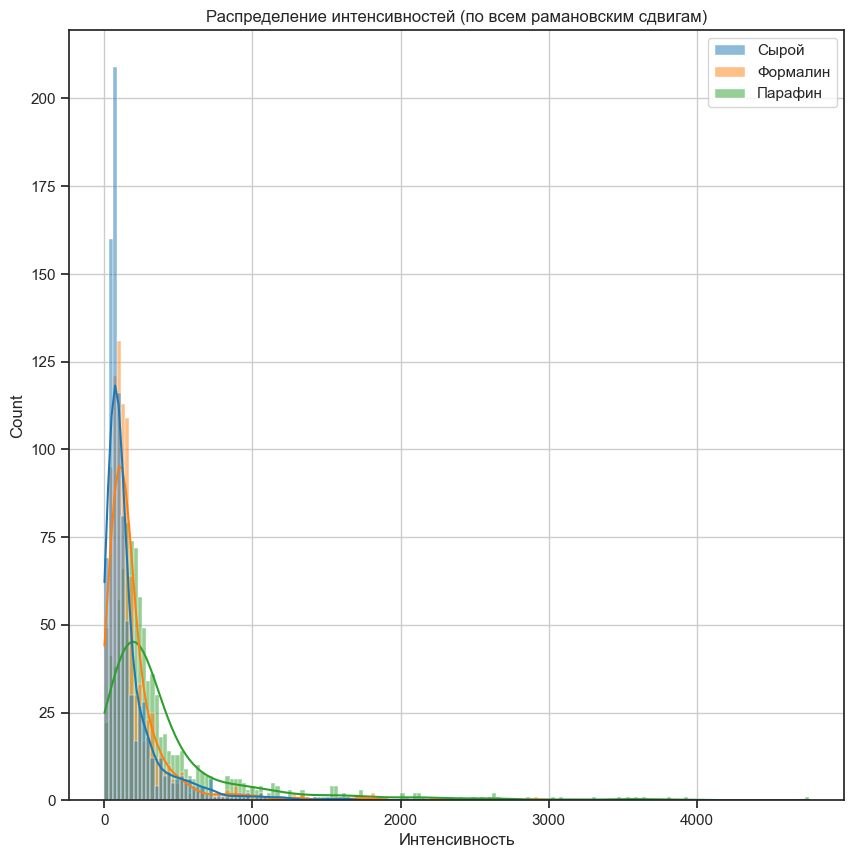

In [111]:
# гистограммы интенсивности флуоресценции в зависимости от вещества
fig = plt.figure(figsize=(10, 10))
sns.histplot(data[['Сырой', 'Формалин', 'Парафин']], kde=True)
plt.title('Распределение интенсивностей (по всем рамановским сдвигам)')
plt.xlabel('Интенсивность')
plt.show()

## Построение моделей градиентного бустинга

Для справки:<br>Градиентный бустинг - это ансамблевый метод построения моделей машинного обучения. Основная идея состоит в том, чтобы объединить множество деревьев решений в одну модель. Градиентный бустинг строит серию деревьев, где каждое дерево обучается на ошибке - разнице между истинным и прогнозируемым значением - предыдущего дерева. С каждым раундом предсказание ансамбля улучшается, поскольку каждое дерево подталкивается в правильном направлении с помощью небольших обновлений.<br>В общем случае алгоритм градиентного бустинга состоит из следующих шагов:<br>1 Инициализация базового дерева решений постоянным значением.<br>2 Вычисление разницы (остатков) между значением базового дерева и истинными значениями.<br>3 Обучение нового дерева на остатках.<br>4 Добавление предсказаний дерева к предсказаниям предыдущего дерева с учётом коэффициента скорости обучения.<br>5 Повторение шагов 2 - 5 до достижения заданного числа деревьев.<br>6 Вычисление финального предсказания (среднее значение всех деревьев).
*Модели построены на полном наборе данных вследствие лучшей метрики R2_score.

In [ ]:
def x_to_y(xs, ys):
    """
    
    """
    # выделяем столбцы игреков и иксов
    columns = list(features.columns)
    columns.append('Раман')
    columns.append(xs)
    
    # столбцы для препроцессора
    columns_num = list(features.columns)
    columns_num.append(xs)
    
    # разделение датасета
    x_tr, x_test, y_tr, y_test = train_test_split(
        data[columns],
        data[ys],
        test_size=0.2,
        shuffle=True,
        random_state=RANDOM_STATE
    )
    
    param_grid = [
        {
            'models': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
            'models__learning_rate': [0.01, 0.1, 0.2],
            'models__n_estimators': [150, 250, 400, 500, 750],
            'models__max_features': ['sqrt', 'log2', None],
            'models__max_depth': [3, 4, 5, 6],
            'models__min_samples_leaf': [1, 2, 3]
        }
    ]

    data_preprocessor = ColumnTransformer(
        [
            ('num', 'passthrough', columns_num),
            ('ohe', OneHotEncoder(sparse_output=False), ['Раман'])
        ]
    )

    model = GradientBoostingRegressor(random_state=RANDOM_STATE)

    pipe = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', model)
        ]
    )

    grid_gbr = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    grid_gbr = grid_gbr.fit(x_tr, y_tr)
    
    # сохраняем результаты кросс-валидации
    grid_results = pd.DataFrame()
    grid_results = pd.DataFrame(grid_gbr.cv_results_).sort_values('mean_test_score', ascending=False)
    
    # объявление лучшей модели
    model_gbr = grid_gbr.best_estimator_
    
    # оценка на тесте
    predict_gbr = model_gbr.predict(x_test)
    mae_gbr = mean_absolute_error(y_test, predict_gbr)
    meae_gbr = median_absolute_error(y_test, predict_gbr)
    rmse_gbr = root_mean_squared_error(y_test, predict_gbr)
    r2_gbr = r2_score(y_test, predict_gbr)

    # отчёт
    report = pd.DataFrame(columns=['x', 'y',
                                   'MAE', 'MeAE', 'RMSE', 'R2_score',
                                   'y_test', 'y_pred',
                                   'model_params'])
    report.loc[len(report.index)] = [xs, ys,
                                     mae_gbr, meae_gbr, rmse_gbr, r2_gbr,
                                     y_test.values, predict_gbr,
                                     model_gbr.get_params()['models'].get_params()]
    
    # важности
    feature_importances = pd.DataFrame(columns=model_gbr[0].get_feature_names_out())
    feature_importances.loc[len(feature_importances.index)] = model_gbr[1].feature_importances_
    feature_importances.index = ['Важность, %']
    
    #joblib.dump(model_gbr, f'model_{xs}_to_{ys}.joblib')
    
    return report, feature_importances, grid_results

In [114]:
report_p_to_s, feature_importances_p_to_s, grid_results_p_to_s = x_to_y('Парафин', 'Сырой')
report_p_to_f, feature_importances_p_to_f, grid_results_p_to_f = x_to_y('Парафин', 'Формалин')
report_f_to_s, feature_importances_f_to_s, grid_results_f_to_s = x_to_y('Формалин', 'Сырой')

# Отчёты

In [115]:
report = pd.concat([report_p_to_s, report_p_to_f, report_f_to_s])
grid_results = pd.concat([grid_results_p_to_s, grid_results_p_to_f, grid_results_f_to_s])

In [116]:
feature_importances = pd.concat([feature_importances_p_to_s, feature_importances_p_to_f, 
                                 feature_importances_f_to_s])
feature_importances.index = ['Парафин-Сырой, Важность, %', 'Парафин-Формалин, Важность, %',
                             'Формалин-Сырой, Важность, %']

In [123]:
# сохранение таблиц в Эксель
feature_importances.to_excel('feature_importances.xlsx')
report.to_excel('report.xlsx')
grid_results.to_excel('grid_results.xlsx')

In [121]:
feature_importances['num__Раман'] = feature_importances.iloc[:, 7:-3].sum(axis=1)
feature_importances['Интенсивность'] = feature_importances[['num__Парафин', 'num__Формалин']].sum(axis=1)
print('Относительная важность признаков')
importances = feature_importances[['num__Возраст', 'num__Срок', 'num__Роды', 'num__Апгар',
                                   'num__Масса_плод', 'num__Рост', 'num__Масса_плацента', 
                                   'num__Раман', 'Интенсивность']]
importances.columns = list(features.columns) + ['Раман', 'Интенсивность']
importances

Относительная важность признаков


,Возраст,Срок,Роды,Апгар,Масса_плод,Рост,Масса_плацента,Раман,Интенсивность
"Парафин-Сырой, Важность, %",0.091,0.037,0.046,0.130,0.087,0.103,0.196,0.309,0.144
"Парафин-Формалин, Важность, %",0.043,0.018,0.027,0.022,0.074,0.021,0.067,0.727,0.120
"Формалин-Сырой, Важность, %",0.085,0.049,0.042,0.098,0.121,0.104,0.214,0.154,0.133


In [122]:
report.index = ['Парафин-Сырой', 'Парафин-Формалин', 'Формалин-Сырой']
print('Показатели качества моделей')
report.iloc[:, 2:6]

Показатели качества моделей


,MAE,MeAE,RMSE,R2_score
Парафин-Сырой,64.800,34.136,108.031,0.744
Парафин-Формалин,80.122,47.024,158.954,0.633
Формалин-Сырой,65.531,35.366,108.803,0.740


# Резюме
Приведены описательные статистики набора данных: боксплоты для признаков, относящихся к пациентам, диаграмма рассеяния, показывающая средние значения интенсивностей по рамановским сдвигам для каждого аналита, и парные графики для трёх рамановских сдвигов, показывающие ядерную плотность интенсивностей для каждого аналита.
Проведён тест Шапиро-Уилка на принадлежность данных к нормальному распределению (p-value 0.05): сдвиги, данные которых не принадлежат нормальному распределению для всех аналитов: {'1445.0', '1627.0'}.
Проведён Хи-квадрат тест на независимость данных (p-value 0.05): выборки для всех рамановских сдвигов возможно зависимы.
Проведён тест ANOVA на статистическую значимость различия между средними выборок (p-value 0.05): сдвиги, средние значения которых различны для сырых и парафина: ['415.0', '533.0', '628.0', '641.0', '720.0', '753.0', '810.0', '830.0', '890.0', '1002.0', '1048.0', '1117.0', '1174.0', '1204.0', '1230.0', '1287.0', '1300.0', '1445.0', '2225.0', '2554.0', '2915.0'].
Справочное приведено исключение выбросов по методу IQR.
Проведён регрессионный анализ данных и построены 3 модели для прогнозирования интенсивности рамановского сдвига в одном аналите в зависимости от признаков пациента и интеснивности рамановского сдвига в другом аналите. Модели используют ансамблевый метод построения моделей машинного обучения – градиентный бустинг. Основная идея состоит в том, чтобы объединить множество деревьев решений в одну модель. Градиентный бустинг строит серию деревьев, где каждое дерево обучается на ошибке - разнице между истинным и прогнозируемым значением - предыдущего дерева.
Относительная важность признаков для моделей и показатели качества моделей на тестовой выборке приведены в таблицах.